# Learning of discrete Lagrangian using a certified kernel-based method

In [1]:
Base.active_project()

"/home/christianoffen/UPBownCloud/Paderborn University/L_Learning_via_Collocation/numerical_experiment_discrete_ode/Project.toml"

In [ ]:
using ForwardDiff
using Plots
using LinearAlgebra
using NLsolve
using HaltonSequences
using BlockArrays
using SpecialFunctions
using LaTeXStrings
using Dates
using FileIO

In [301]:
using ProgressMeter

In [162]:
#include("EL_utilities.jl");
include("Ld_learning_GP_utilities_ndim.jl");
include("Error_Utilities.jl")

errors_mesh (generic function with 1 method)

In [302]:
include("VariationalMidpointRule.jl")

ComputeTrajectory (generic function with 1 method)

In [164]:
mNow() = string(Dates.format(now(), "yyyy-mm-dd_HH:MM:SS"));
println("Start: "*mNow())

Start: 2024-04-24_14:09:25


## Reference system / true system

In [5]:
dimQ=2
dimQQ = 2*dimQ;

In [6]:
## coupled harmonic oscillators
coupling_constant = 0.1
L_ref(q,qdot) = 1/2*sum(qdot.^2) - sum(q.^2) + coupling_constant*prod(q)

## make available on jet variables
L_ref(qjet) = L_ref(qjet[1:dimQ],qjet[dimQ+1:end])

## Hamiltonian
H_ref_dyn(q,qdot) = dot(qdot,ForwardDiff.gradient(Base.Fix1(L_ref,q),qdot))-L_ref(q,qdot)

## Hamiltonian (as qdot = p in this case)
H_ref(q,p) = dot(p,p) - L_ref(q,p)
H_ref(z) = H_ref(z[1:dimQ],z[dimQ+1:end])

H_ref (generic function with 2 methods)

In [7]:
h_ref = 0.01
Ld_ref = LdMP(L_ref,h_ref);
Ld_Rf(z) = Ld_ref(z[1:dimQ],z[dimQ+1:end])

Ld_Rf (generic function with 1 method)

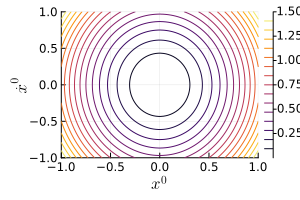

In [472]:
delta = 1
xx = range(-delta, delta, length=80)
yy = range(-delta, delta, length=80)

x=(a->[a;0]).(xx)
y=(a->[a;0]).(yy)

pcontourHref0=contour(xx, yy, H_ref_dyn.(x',y),xlabel=L"x^0",ylabel=L"\dot x^0")
plot!(size=(300,200));
#savefig(pcontourHref0,"plots/ContourHref0_"*mNow()*".pdf")

In [456]:
q0_0 = [0.2, 0.1]
p0_0 = [0.1, 0.]
T_0 = 100
steps_0 = Int(T_0/h_ref)
tt_0 = 0:h_ref:steps_0*h_ref
ftol_0 = 1e-9

1.0e-9

In [457]:
sol_ref_0 = ComputeTrajectory(Ld_ref,q0_0,p0_0,steps_0,ftol=ftol_0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


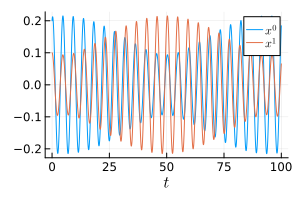

In [474]:
pSolRef0=plot(tt_0,sol_ref_0[1,:],label=L"x^0",xlabel=L"t")
plot!(tt_0,sol_ref_0[2,:],label=L"x^1")
plot!(size=(300,200))
#savefig(pSolRef0,"plots/SolRef0_"*mNow()*".pdf")

In [459]:
sol_ref_p_0 = ConjugateMomenta_p0(Ld_ref,sol_ref_0);

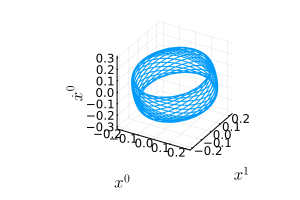

In [478]:
pSolRefPhase0=plot(sol_ref_0[1,:],sol_ref_0[2,:],sol_ref_p_0[1,:],xlabel=L"x^0",ylabel=L"x^1",zlabel=L"\dot x^0",label="")
plot!(size=(300,200))

In [462]:
#savefig(pSolRefPhase0,"plots/SolRefPhase0_"*mNow()*".pdf")

In [464]:
sol_ref_H_0 = mapslices(H_ref,[sol_ref_0; sol_ref_p_0],dims=1);

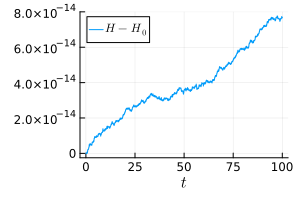

In [479]:
pHamSolRef0=plot(tt_0,sol_ref_H_0' .- sol_ref_H_0[1,1],xlabel=L"t",label=L"H-H_0")
plot!(size=(300,200))

In [467]:
#savefig(pHamSolRef0,"plots/HamSolRef0_"*mNow()*".pdf")

## Data generation 

In [16]:
# samples and domain
NSamples = 300
domain_bnd = [1., 1.,1.,1.]
basept = [0.,0.,0.,0.]
h=0.1
steps_internal=10

Ld_ref_data_gen = LdMP(L_ref,h/steps_internal)

bnd_value = [1., 1., 1.] # normalisation of conj. momentum of L and value of L at base point

samples_per_unit = NSamples/prod(domain_bnd*2)
println("samples per unit: "*string(samples_per_unit))

data_QP=HaltonPoint(2*dimQ,length=NSamples)
data_QP=(a->domain_bnd.*(-ones(2*dimQ) .+ 2.0*a)).(data_QP);

samples per unit: 18.75


In [17]:
# compute (q0,q1,q2) of a trajectory (highly accurately computed) initialised at (q0,p0)
q_step_ref_data_gen(y::Vector) = ComputeTrajectory(Ld_ref_data_gen,y[1:dimQ],y[dimQ+1:end],2*steps_internal;ftol=1e-9)[:,[1;steps_internal+1;2*steps_internal+1]] 

data_QQQ_collect=q_step_ref_data_gen.(data_QP);
data_QQQ=(x->x[:]).(data_QQQ_collect);
data_QQ=(x->x[1:2*dimQ]).(data_QQQ);
#Data=cat(data_QQQ...,dims=3);

In [18]:
#predicted size of linear problem in training / predictions
size_theta = dimQ*(NSamples+1)+1
println("predicted size of linear problem "*string(size_theta)*"x"*string(size_theta))

predicted size of linear problem 603x603


In [501]:
function data_plot(pl,indx)
    pl=plot!(data_QQQ_collect[indx][1,:],data_QQQ_collect[indx][2,:],marker=:circle, label="", markersize=1.3)
end

data_plot (generic function with 1 method)

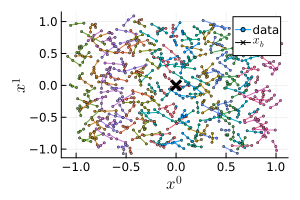

In [504]:
pl_data=plot(data_QQQ[1][1,:],data_QQQ[1][2,:],marker=:circle, label="data", markersize=1.3)
(Base.Fix1(data_plot,pl_data)).(2:NSamples);

pl_data = plot!(xlabel=L"x^0",ylabel=L"x^1")
plot!([0.],[0.],marker=:x,markersize=:5,color=:black,label=L"x_b",markerstrokewidth=8)
plot!(size=(300,200))

In [506]:
#savefig(pl_data,"plots/pl_data_"*mNow()*".pdf")

## kernel definition

In [22]:
# kernel definition
lengthscale = 1*ones(dimQQ); #[0.9; 0.9; 0.9; 0.9]

# squared exponential
kernel(a,b) = exp(-0.5*sum(((a-b)./lengthscale).^2))
kernel(x0,x1,q0,q1) = kernel([x0;x1],[q0;q1])

kernel (generic function with 2 methods)

In [23]:
vol_n_ball = pi^(dimQQ/2)/gamma(dimQQ/2+1)*prod(lengthscale)
samples_per_lengthscale_ball = vol_n_ball*samples_per_unit
println("# samples within length scale: "*string(samples_per_lengthscale_ball))

# samples within length scale: 92.52754126021273


## Computation of posterior

In [165]:
println("Define Ld_ml and variances "*mNow())

Define Ld_ml and variances 2024-04-24_14:09:52


In [166]:
Ld_ml, var_ml_operator, var_ml_pts, var_ml_p, Theta = Lagrangian_Gamblet(kernel,data_QQQ,basept; normalisation_balancing=bnd_value);
println(mNow())

2024-04-24_14:10:35


## Evaluation

In [167]:
# check normalisation
println("Normalisation: ")
println("Ld_ml(basept) "*string(Ld_ml(basept))*", p_ml(basept) "*string(conjp(Ld_ml,basept)))

Normalisation: 
Ld_ml(basept) 1.0000000001877711, p_ml(basept) [0.9999999999357787, 1.0000000000326785]


In [168]:
# check whether variance of EulerLagrange operator (interpreted as observable) is zero on data
var_ml_el = var_ml_operator.( [L-> (qjet -> del(L,qjet)[j]) for j=1:dimQ]);

max_var_ml=[maximum(abs.(var_ml_el[j].(data_QQQ))) for j=1:dimQ]
println("Max var_ml_del(Ld_ml,data) "*string(max_var_ml))

Max var_ml_del(Ld_ml,data) [2.886579864025407e-15, 3.552713678800501e-15]


In [169]:
# conditioning of linear problem in gamblet evaluation
println("Condition linear problem in evaluations "*string(cond(Theta)))

Condition linear problem in evaluations 1.5047791816397075e15


In [170]:
# Test how well collocation conditions are fulfilled
collocation_test = Base.Fix1(del,Ld_ml).(data_QQQ)
mCollTest=maximum(abs.(hcat(collocation_test...))) # max error EL

println("Max del(Ld_ml,data) "*string(mCollTest))

Max del(Ld_ml,data) 1.7840434685112427e-9


In [509]:
# test domain (q,p_ref), where p relates to reference Lagrangian

deltaTestx = 1
deltaTesty = 1

xx = range(-deltaTestx, deltaTestx, length=30)
yy = range(-deltaTesty, deltaTesty, length=31)

x=(a->[a;0]).(xx)
y=(a->[a;0]).(yy)
x2=(a->[0;a]).(xx);

In [510]:
# test how well del is fulfilled on reference trajectory data (q0,q1,q2)

function del_test(q::Vector{Float64},p::Vector{Float64})
    qqq=q_step_ref_data_gen([q;p])[:]
    return del(Ld_ml,qqq)
end

del_test (generic function with 2 methods)

In [420]:
del_test_vals=(b->Base.Fix2(del_test,b).(x)).(y);

In [421]:
del_test_vals=hcat(del_test_vals...);

In [511]:
dxdy=(xx[2]-xx[1])*(yy[2]-yy[1])
abs_errs, _, abs_err, _ = errors_mesh(del_test_vals, [[0.,0.] for x in x, y in y],dxdy);
println("discrete l1,l2,linf del failure: "*string(abs_errs))

discrete l1,l2,linf del failure: [4.0250572917552315e-6, 5.549385821828349e-6, 3.592930469225193e-5]


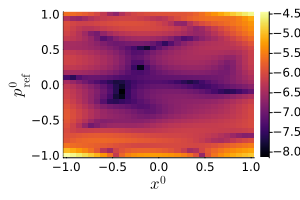

In [519]:
p_del_test=heatmap(yy,xx,log10.(norm.(del_test_vals)),xlabel=L"x^0",ylabel=L"p^0_{\mathrm{ref}}")
plot!(size=(300,200),right_margin=2Plots.mm)

In [424]:
#savefig(p_del_test,"plots/p_del_test_"*mNow()*".pdf")

In [425]:
var_ml_el_norm(qqq) = norm((ind -> var_ml_el[ind](qqq)).(1:dimQ),Inf)

var_ml_el_norm (generic function with 1 method)

In [426]:
function var_ml_el_norm_qp(q,p)
    qqq = q_step_ref_data_gen([q;p])[:]
    return var_ml_el_norm(qqq)
end

var_ml_el_norm_qp (generic function with 1 method)

In [427]:
var_ml_el_norm_qp_vals = zeros(length(x),length(y))
@showprogress for i=1:length(x), j=1:length(y)
    var_ml_el_norm_qp_vals[i,j]=var_ml_el_norm_qp(x[i],y[j])
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


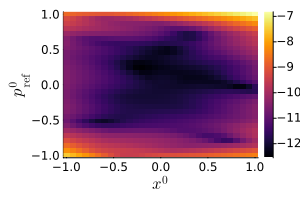

In [523]:
p_var_del=heatmap(yy,xx,log10.(var_ml_el_norm_qp_vals),xlabel=L"x^0",ylabel=L"p^0_{\mathrm{ref}}")
plot!(size=(300,200),right_margin=1Plots.mm)

In [430]:
var_ml_el_norm_qp_vals_p0 = zeros(length(x),length(x))
@showprogress for i=1:length(x), j=1:length(x)
    var_ml_el_norm_qp_vals_p0[i,j]=var_ml_el_norm_qp([xx[i];xx[j]],zeros(dimQ))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


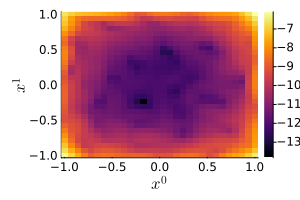

In [526]:
p_var_del_p0=heatmap(xx,xx,log10.(var_ml_el_norm_qp_vals_p0),xlabel=L"x^0",ylabel=L"x^1")
plot!(size=(300,200),right_margin=1Plots.mm)

In [434]:
#savefig(p_var_del,"plots/p_var_del_"*mNow()*".pdf")
#savefig(p_var_del_p0,"plots/p_var_del_p0_"*mNow()*".pdf")

In [343]:
# dynamics prediction
T = 100.
q0 = [0.2,0.1]
p0 = [0.,0.];

h_ref = h/steps_internal
steps = Int(T/h)
steps_ref = Int(steps*steps_internal)
tt_ref = 0:h_ref:h_ref*steps_ref
tt = 0:h:h*steps

0.0:0.1:100.0

In [344]:
println("Compute dynamics - reference model "*mNow())
sol1_ref = ComputeTrajectory(Ld_ref_data_gen,q0,p0,steps_ref;ftol=1e-9,maxIterNewton=100);

Compute dynamics 2024-04-24_15:54:56


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [345]:
q1 = sol1_ref[:,steps_internal+1];

In [346]:
println("Compute dynamics - ml model "*mNow())
sol1_ml = DELSolve(Ld_ml,q0,q1,steps;ftol=1e-10);

Compute dynamics 2024-04-24_15:54:58


Progress: 100%|█████████████████████████████████████████| Time: 0:06:11


In [279]:
del_accuracy_trajectory=[del(Ld_ml,sol1_ml[:,j:j+2][:]) for j=1:steps-1];

In [280]:
println("max abs error del(Ld_ml,.) along trajectory: "*string(maximum(abs.(hcat(del_accuracy_trajectory...)))))

max abs error del(Ld_ml,.) along trajectory: 1.1323320059375419e-10


In [347]:
println("Plotting/Saving of results "*mNow())

Plotting/Saving of results 2024-04-24_16:01:09


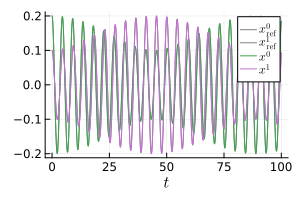

In [527]:
pcompareDyn=plot(tt,sol1_ml',linestyle=:solid,color=:gray,label=[L"x^0_\mathrm{ref}" L"x^1_\mathrm{ref}"])
plot!(tt_ref[1:steps_internal:end],sol1_ref[:,1:steps_internal:end]',xlabel=L"t",label=[L"x^0" L"x^1"])
plot!(size=(300,200))
#savefig(pcompareDyn,"plots/pcompareDyn_"*mNow()*".pdf")

In [349]:
# midpoint approximation of velocities
vel_sol1_ref = (sol1_ref[:,1:steps_internal:end][:,3:end]-sol1_ref[:,1:steps_internal:end][:,1:end-2])/(2*h);
vel_sol1_ml = (sol1_ml[:,3:end]-sol1_ml[:,1:end-2])/(2*h);

In [351]:
#var_ml_el_trajectory=[var_ml_el_norm(sol1_ml[:,j:j+2][:]) for j in 1:steps-1];
#println("max variance along trajectory "*string(norm(var_ml_el_trajectory,Inf)))

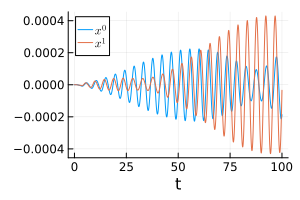

In [530]:
err_trj=sol1_ref[:,1:steps_internal:end]-sol1_ml;
pErrTrj=plot(tt,err_trj',xlabel="t",label=[L"x^0" L"x^1"])
plot!(size=(300,200))
#savefig(pErrTrj,"plots/pErrTrj_"*mNow()*".pdf")

In [538]:
println("max abs error of trajectory: "*string(maximum(abs.(err_trj))))

max abs error of trajectory: 0.0004299372121709666


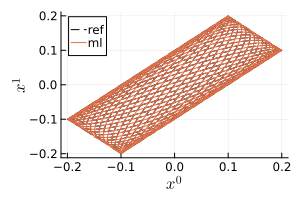

In [532]:
pcomparePhase=plot(sol1_ref[1,1:steps_internal:end],sol1_ref[2,1:steps_internal:end],xlabel=L"x^0",ylabel=L"x^1",label="ref",color=:black,linestyle=:dash)
plot!(sol1_ml[1,:],sol1_ml[2,:],label="ml")
plot!(size=(300,200))

In [533]:
#savefig(pcomparePhase,"plots/pcomparePhase_"*mNow()*".pdf")

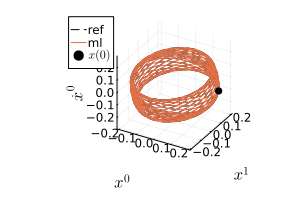

In [535]:
pcomparePhase3d=plot(sol1_ref[1,1:steps_internal:end][2:end-1],sol1_ref[2,1:steps_internal:end][2:end-1],vel_sol1_ref[1,:],xlabel=L"x^0",ylabel=L"x^1",zlabel=L"\dot x^0",label="ref",color=:black,linestyle=:dash)
plot!(sol1_ml[1,2:end-1],sol1_ml[2,2:end-1],vel_sol1_ml[1,:],label="ml")
scatter!(sol1_ml[1:1,2],sol1_ml[2:2,2],vel_sol1_ml[1:1,1],color=:black,label=L"x(0)")
plot!(size=(300,200))

In [536]:
#savefig(pcomparePhase3d,"plots/pcomparePhase3d_"*mNow()*".pdf")

In [357]:
# save ode solution / energy / variance
save("OdeSolution "*mNow()*".jld2","sol1_ref",sol1_ref,"sol1_ml",sol1_ml,"del_accuracy_trajectory",del_accuracy_trajectory,"var_ml_el_trajectory",var_ml_el_trajectory)

In [358]:
println("End of script "*mNow())

End of script 2024-04-24_16:01:53


In [68]:
# load
#loadData = load("OdeSolution date.jld2")
#sol1_ref = loadData["sol1_ref"]
#sol1_ml = loadData["sol1_ml"]

In [539]:
#using NBInclude
#nbexport("Ld_Learning_CertifiedGP.jl", "Ld_Learning_CertifiedGP.ipynb")

[ Info: Precompiling NBInclude [0db19996-df87-5ea3-a455-e3a50d440464]
